# Main functions used in experiments

In [80]:
import numpy as np
from collections import defaultdict
import pandas as pd
import plotly.graph_objects as go
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer
%matplotlib inline
import matplotlib.pyplot as plt
import sys

import random
import time
assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

## Environment

In [272]:
from windy_gridworld import WindyGridworldEnv
env = WindyGridworldEnv()
env??

# import gym
# env = gym.envs.make("FrozenLake-v0")
# env.env.__init__(is_slippery=False)

Type:            WindyGridworldEnv
String form:     <WindyGridworldEnv instance>
File:            ~/Documents/Master AI/Reinforcement Learning/RL_reproducibility/windy_gridworld.py
Source:         
class WindyGridworldEnv(discrete.DiscreteEnv):

    metadata = {'render.modes': ['human', 'ansi']}

    def _limit_coordinates(self, coord):
        coord[0] = min(coord[0], self.shape[0] - 1)
        coord[0] = max(coord[0], 0)
        coord[1] = min(coord[1], self.shape[1] - 1)
        coord[1] = max(coord[1], 0)
        return coord

    def _calculate_transition_prob(self, current, delta, winds):
        new_position = np.array(current) + np.array(delta) + np.array([-1, 0]) * winds[tuple(current)]
        new_position = self._limit_coordinates(new_position).astype(int)
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)
        is_done = tuple(new_position) == (3, 7)
        return [(1.0, new_state, -1.0, is_done)]

    def __init__(self):
        self.shape = (7, 1

In [273]:
try:
    env.nA = env.env.nA
    env.nS = env.env.nS
except:
    pass

## Policy

In [4]:
class GreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q):
        self.Q = Q
    
    def get_probs(self, state, action):
        """
        This method takes a list of states and a list of actions and returns a numpy array that contains 
        a probability of perfoming action in given state for every corresponding state action pair. 

        Args:
            states: a list of states.
            actions: a list of actions.

        Returns:
            Numpy array filled with probabilities (same length as states and actions)
        """   
        # for state and action only:
        action_probs = self.Q[state]
        max_indices = np.argwhere(action_probs == np.amax(action_probs))
        
        if action in max_indices:
            prob = 1/len(max_indices)
        else:
            prob = 0
        
        return prob
        
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """
        best_action = np.random.choice([i for i, j in enumerate(self.Q[obs]) if j == np.max(self.Q[obs])])
        
        return best_action

In [5]:
class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon
        
    def get_probs(self, state, action):
        # for one state and action 
        action_probs = self.Q[state]
        max_indices = np.argwhere(action_probs == np.amax(action_probs))
        # all probs are equal, give all equal probabilities
        if len(max_indices) == len(action_probs):
            return 1/len(max_indices)
            
        if action in max_indices:
            prob = (1-self.epsilon)/len(max_indices)
        else:
            prob = epsilon / (len(action_probs) - len(max_indices))
        
        return prob
        
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """
        p = np.random.uniform()
        if p > self.epsilon:
            # choose one of the best actions
            action = np.random.choice([i for i, j in enumerate(self.Q[obs]) if j == np.max(self.Q[obs])])
        else:
            # return a random action
            action = np.random.randint(0,4)
                
        return action

## Monte Carlo

In [6]:
def sample_episode(env, policy):
    """
    A sampling routine. Given environment and a policy samples one episode and returns states, actions, rewards
    and dones from environment's step function and policy's sample_action function as lists.

    Args:
        env: OpenAI gym environment.
        policy: A policy which allows us to sample actions with its sample_action method.

    Returns:
        Tuple of lists (states, actions, rewards, dones). All lists should have same length. 
        state after the termination is not included in the list of states.
    """
    # initialize
    states = []
    actions = []
    rewards = []
    dones = []
    
    # get a starting state
    s = env.reset()
    d = False
    
    # keep looping until done, don's save the terminal state
    while not d:
        states.append(s)
        a = policy.sample_action(s)
        s, r, d, _ = env.step(a)
        
        # save                
        actions.append(a)
        rewards.append(r)
        dones.append(d)
        

    return states, actions, rewards, dones

In [7]:
# check the length of episodes that are generated for eps greedy policy
Q = np.zeros((env.nS, env.nA))
bp = EpsilonGreedyPolicy(Q, epsilon=0.1)

for episode in range(1):
    trajectory_data = sample_episode(env, bp)
#     print("Episode {}:\nStates {}\nActions {}\nRewards {}\nDones {}\n".format(episode,*trajectory_data))
    print(f"length of episode {episode}: {len(trajectory_data[0])}")

length of episode 0: 6


## MC Ordinary Importance Sampling

In [8]:
def Qdefaultdict2array(Q, nA, nS):
    Q_np = np.zeros((nS, nA))
    for S in range(nS):
        for A in range(nA):
            Q_np[S][A] = Q[S][A]
    return Q_np

In [9]:
def mc_importance_sampling(env, behavior_policy, target_policy, num_episodes, weighted=False, discount_factor=1.0,
                           sampling_function=sample_episode, epsilon=0.05, seed=42, 
                           analyse_states=[(0,2), (0,1), (14,2), (2,1), (8,2)]):
    """
    Monte Carlo prediction algorithm. Calculates the Q function
    for a given target policy using behavior policy and ordinary importance sampling.
    
    Args:
        env: OpenAI gym environment.
        behavior_policy: A policy used to collect the data.
        target_policy: A policy which value function we want to estimate.
        num_episodes: Number of episodes to sample.
        weighted: Boolean flag to use weighted or ordinary importance sampling.
        discount_factor: Gamma discount factor.
        sampling_function: Function that generates data from one episode.
    
    Returns:
        A dictionary that maps from (state, action) -> value.
    """

    # set the current Q to a large negative value
    Q = np.zeros((env.nS, env.nA))
    if weighted:
        C = np.zeros((env.nS, env.nA))
    else:
        returns_count = defaultdict(lambda: defaultdict(float))
    
    episode_lens = []
    
    # set seed
    np.random.seed(seed)
    
    analysis_values = dict((k,[]) for k in analyse_states)
    
    # sample episodes
    for i in tqdm(range(num_episodes), position=0):
        # update behavioral and target policy
        behavior_policy.Q = Q
        target_policy.Q = Q        
    
        # sample episode with new behavioural function
        states, actions, rewards, dones = sampling_function(env, behavior_policy)
        
        # save the episode length
        episode_lens.append(len(states)) 

        G = 0        
        W = 1
        
        # loop backwards over the trajectory
        for i, timestep in enumerate(range(len(states)-1, -1, -1)):
            s = states[timestep]
            r = rewards[timestep]
            a = actions[timestep]
            G = discount_factor * G + r
                        
            if weighted:
                # add W to the sum of weights C
                C[s][a] += W
                Q[s][a] += W/C[s][a] * (G - Q[s][a])
            else:
                returns_count[s][a] += 1 
                # use every visit incremental method
                Q[s][a] += 1/returns_count[s][a] * W * (G - Q[s][a])

            W *= (target_policy.get_probs(s, a)) / (behavior_policy.get_probs(s, a))        

            if W == 0:
                break

        # store state values to analyse
        for (s,a) in analyse_states:
#             print(Q[s][a])
            analysis_values[(s,a)].append(Q[s][a])
            
    return Q, episode_lens, analysis_values

## Performance

In [10]:
# Reproducible
seed = 42

# set other parameters
epsilon = 0.1
gamma = 0.99
num_episodes = 1000
Q = np.zeros((env.nS, env.nA))
behavioral_policy = EpsilonGreedyPolicy(Q, epsilon=epsilon)
target_policy = GreedyPolicy(Q)

# the episode length is equal to the negative return. 
print(f"Updating Q using ordinary importance sampling ({num_episodes} episodes)")
Q_mc_ordinary, mc_ordinary_epslengths, mc_analysis_ordinary = mc_importance_sampling(env,
                                                               behavioral_policy, target_policy, 
                                                               num_episodes, weighted=False,discount_factor=gamma, 
                                                               epsilon=epsilon, seed=seed)

print(f"Updating Q using weighted importance sampling ({num_episodes} episodes)")
Q_mc_weighted, mc_weighted_epslengths, mc_analysis_weighted = mc_importance_sampling(env,
                                                               behavioral_policy, target_policy,
                                                               num_episodes, weighted=True, discount_factor=gamma, 
                                                               epsilon=epsilon, seed=seed)

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating Q using ordinary importance sampling (1000 episodes)


  0%|          | 0/1000 [00:00<?, ?it/s]

Updating Q using weighted importance sampling (1000 episodes)


100%|██████████| 1000/1000 [00:00<00:00, 1346.77it/s]


In [11]:
# check how long an episode takes under the found Q function
mc_greedy_ordinary = GreedyPolicy(Q_mc_ordinary)
mc_greedy_weighted = GreedyPolicy(Q_mc_weighted)

mc_ordinary_episode = sample_episode(env, mc_greedy_ordinary)
mc_weighted_episode = sample_episode(env, mc_greedy_weighted)

print(f"resulting episode length ordinary: {len(mc_ordinary_episode[0])}")
print(f"resulting episode length weighted: {len(mc_weighted_episode[0])}")

resulting episode length ordinary: 6
resulting episode length weighted: 6


## Plotting

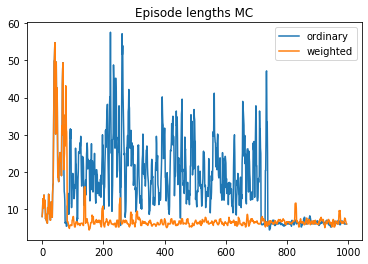

In [12]:
def running_mean(vals, n=1):
    assert n < len(vals)
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n 

# set smoothing factor
n = 5

plt.plot(running_mean(mc_ordinary_epslengths, n), label="ordinary")
plt.plot(running_mean(mc_weighted_epslengths, n), label="weighted")
# plt.hlines(num_episodes)
plt.title('Episode lengths MC')
# plt.yscale("log")
plt.legend()
# plt.gca().set_ylim([0, 100])
plt.show()

## Temporal Difference

To-Do: Check n-step implementation so we can drop the first sarsa

In [13]:
# def sarsa_ordinary_importance_sampling(env, behavior_policy, target_policy, num_episodes, discount_factor=1.0, alpha=0.5):
#     """
#     SARSA algorithm: Off-policy TD control. Calculates the value function
#     for a given target policy using behavior policy and ordinary importance sampling.
    
#     Args:
#         env: OpenAI environment.
#         policy: A policy which allows us to sample actions with its sample_action method.
#         Q: Q value function, numpy array Q[s,a] -> state-action value.
#         num_episodes: Number of episodes to run for.
#         discount_factor: Gamma discount factor.
#         alpha: TD learning rate.
        
#     Returns:
#         A tuple (Q, stats).
#         Q is a numpy array Q[s,a] -> state-action value.
#         stats is a list of tuples giving the episode lengths and returns.
#     """
    
#     # Keep track of useful statistics
#     stats = []
    
#     Q = np.zeros((env.nS, env.nA))
    
#     for i_episode in tqdm(range(num_episodes)):
#         i = 0
#         R = 0
        
#         behavior_policy.Q = Q
#         target_policy.Q = Q
            
#         s = env.reset()
#         a = behavior_policy.sample_action(s)
        
#         while True:
#             # Take action
#             s_prime, r, final_state, _ = env.step(a)
            
#             # Sample action at from next state
#             a_prime = behavior_policy.sample_action(s_prime)
            
#             # Update weight
#             W = (target_policy.get_probs([s_prime],[a_prime]))/(behavior_policy.get_probs([s_prime],[a_prime]))

#             # Update Q 
#             Q[s][a] += alpha * W * (r + discount_factor * Q[s_prime][a_prime] - Q[s][a])    
            
#             s = s_prime
#             a = a_prime
            
#             R += r
#             i += 1 
            
#             if final_state:
#                 break
            
#         stats.append((i, R))
                
#     episode_lengths, episode_returns = zip(*stats)
#     return Q, (episode_lengths, episode_returns)

In [274]:
def sarsa_importance_sampling(env, behavior_policy, target_policy, num_episodes, weighted=False, discount_factor=1.0, alpha=0.5):
    """
    SARSA algorithm: Off-policy TD control. Calculates the value function
    for a given target policy using behavior policy and ordinary importance sampling.
    
    Args:
        env: OpenAI environment.
        policy: A policy which allows us to sample actions with its sample_action method.
        Q: Q value function, numpy array Q[s,a] -> state-action value.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    
    # Keep track of useful statistics
    num_steps = []
    
    Q = np.zeros((env.nS, env.nA))
    C = np.zeros((env.nS, env.nA))
    Q_dict = {}
    
    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        W = 1
        
        behavior_policy.Q = Q
        target_policy.Q = Q
            
        s = env.reset()
        a = behavior_policy.sample_action(s)
        
        while True:
            # Take action
            s_prime, r, final_state, _ = env.step(a)
            
            # Sample action at from next state
            a_prime = behavior_policy.sample_action(s_prime)
            
            # Update weight
            W = (target_policy.get_probs([s_prime],[a_prime]))/(behavior_policy.get_probs([s_prime],[a_prime]))
#             print(" ")
#             print(final_state)
#             print(W)
#             print((target_policy.get_probs([s],[a]))/(behavior_policy.get_probs([s],[a])))

#             if final_state:
#                 W = 1
            if W == 0:
                break
            
            if weighted:
#                 C[s][a] = W# + (target_policy.get_probs([s],[a]))/(behavior_policy.get_probs([s],[a]))
                Q[s][a] += alpha * (r + discount_factor * Q[s_prime][a_prime] - Q[s][a])
            else:
#                 C[s][a] = 1
                Q[s][a] += alpha * W * (r + discount_factor * Q[s_prime][a_prime] - Q[s][a]) 
#             print(C)
            
#             if C[s][a] == 0:
#                 break
                
            # Update Q 
#             Q[s][a] += alpha * W/C[s][a] * (r + discount_factor * Q[s_prime][a_prime] - Q[s][a])   
            
            
            s = s_prime
            a = a_prime
            
            i += 1 
            
            if final_state:
                break
            
        num_steps.append(i)
        Q_dict[i_episode] = Q.flatten()
                
    return Q, num_steps, Q_dict

In [278]:
# set other parameters
epsilon = 0.05
gamma=0.99
num_episodes = 5000
alpha=0.5
Q = np.zeros((env.nS, env.nA))
behavioral_policy = EpsilonGreedyPolicy(Q, epsilon=epsilon)
target_policy = GreedyPolicy(Q)

print(f"Updating Q using ordinary importance sampling ({num_episodes} episodes)")
Q_td_ordinary, td_ordinary_steps, _ = sarsa_importance_sampling(env, behavioral_policy, target_policy,
                                                                        num_episodes, False, gamma, alpha)

print(f"Updating Q using weighted importance sampling ({num_episodes} episodes)")
Q_td_weighted, td_weighted_steps, _ = sarsa_importance_sampling(env, behavioral_policy, target_policy,
                                                                        num_episodes, True, gamma, alpha)



  0%|          | 0/5000 [00:00<?, ?it/s]

Updating Q using ordinary importance sampling (5000 episodes)




  5%|▍         | 241/5000 [00:01<00:19, 240.84it/s]

 15%|█▍        | 748/5000 [00:02<00:14, 285.83it/s]

 24%|██▍       | 1222/5000 [00:03<00:11, 324.35it/s]

 36%|███▌      | 1796/5000 [00:04<00:08, 373.00it/s]

 48%|████▊     | 2384/5000 [00:05<00:06, 418.85it/s]

 56%|█████▋    | 2820/5000 [00:06<00:05, 419.87it/s]

 66%|██████▋   | 3325/5000 [00:07<00:03, 442.12it/s]

 77%|███████▋  | 3854/5000 [00:08<00:02, 464.97it/s]

 89%|████████▊ | 4437/5000 [00:09<00:01, 494.97it/s]

100%|██████████| 5000/5000 [00:09<00:00, 505.48it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Updating Q using weighted importance sampling (5000 episodes)




  5%|▌         | 253/5000 [00:01<00:18, 252.81it/s]

 14%|█▎        | 681/5000 [00:02<00:14, 288.18it/s]

 22%|██▏       | 1118/5000 [00:03<00:12, 320.88it/s]

 32%|███▏      | 1592/5000 [00:04<00:09, 355.23it/s]

 43%|████▎     | 2146/5000 [00:05<00:07, 397.91it/s]

 53%|█████▎    | 2657/5000 [00:06<00:05, 426.17it/s]

 64%|██████▎   | 3179/5000 [00:07<00:04, 450.90it/s]

 75%|███████▌  | 3768/5000 [00:08<00:02, 484.74it/s]

 87%|████████▋ | 4371/5000 [00:09<00:01, 514.90it/s]

100%|█████████▉| 4989/5000 [00:10<00:00, 542.00it/s]

100%|██████████| 5000/5000 [00:10<00:00, 497.94it/s]

In [284]:
Q_td_ordinary

array([[-16.88557597, -16.62727383, -16.81081911, -16.8049636 ],
       [-16.81182753, -16.28572738, -16.21691639, -16.66157869],
       [-16.34850084, -15.77976548, -15.98971934, -16.20117174],
       [-15.43860193, -13.24732658, -15.8164263 , -15.74219669],
       [-12.4241107 , -10.58724565, -15.02834415, -15.10997354],
       [-11.44547291,  -9.82668352, -14.04308158, -14.06233075],
       [ -9.89828175,  -8.81259182, -13.15312618, -13.75482887],
       [ -8.93898821,  -7.7942198 , -12.96574255, -12.86709336],
       [ -9.32910432,  -6.81058509, -12.03246741, -11.99476674],
       [ -8.23351696, -10.9973441 ,  -5.85392068, -11.26338831],
       [-16.65428793, -16.68824421, -16.72823586, -16.68296676],
       [-16.4156766 , -16.18057052, -16.27628181, -16.78867032],
       [-15.73799649, -13.9045363 , -15.84261188, -15.95219499],
       [-15.40393016, -11.61983428, -15.36729806, -15.15726096],
       [-13.06459861, -10.73611831, -14.45617432, -14.90908434],
       [-10.71867114,  -9

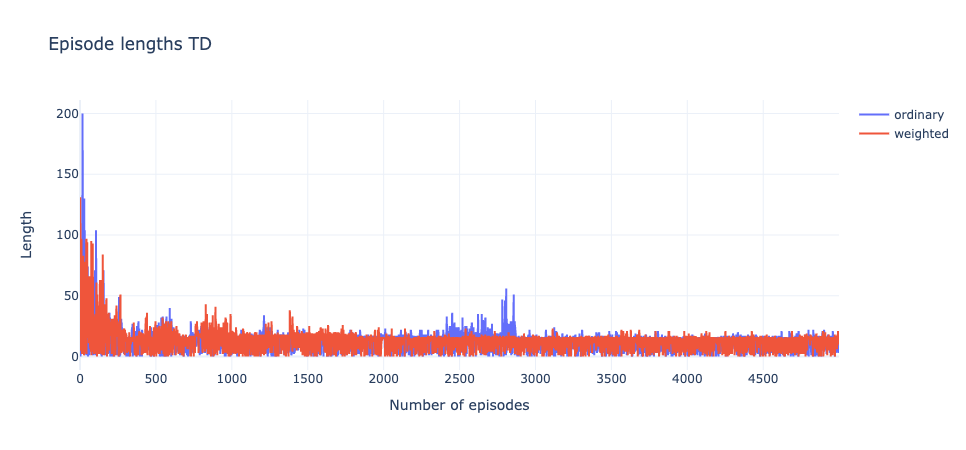

In [279]:
fig = go.Figure(go.Scatter(x=list(range(num_episodes)), y=td_ordinary_steps, name="ordinary"))
fig.add_trace(go.Scatter(y=td_weighted_steps, name="weighted"))
fig.update_layout(title_text="Episode lengths TD", template="plotly_white", yaxis_title="Length", xaxis_title="Number of episodes")
fig.show()

In [281]:
# check how long an episode takes under the found Q function
greedy_ordinary = GreedyPolicy(Q_td_ordinary)
greedy_weighted = GreedyPolicy(Q_td_weighted)

ordinary_episode = sample_episode(env, greedy_ordinary)
weighted_episode = sample_episode(env, greedy_weighted)

print(f"resulting episode length ordinary: {len(ordinary_episode[0])}")
print(f"resulting episode length weighted: {len(weighted_episode[0])}")

resulting episode length ordinary: 15
resulting episode length weighted: 15




  0%|          | 0/5000 [00:00<?, ?it/s]

  7%|▋         | 358/5000 [00:01<00:12, 357.90it/s]

 17%|█▋        | 861/5000 [00:02<00:10, 391.71it/s]

 28%|██▊       | 1391/5000 [00:03<00:08, 424.86it/s]

 40%|███▉      | 1991/5000 [00:04<00:06, 465.60it/s]

 52%|█████▏    | 2595/5000 [00:05<00:04, 499.97it/s]

 63%|██████▎   | 3157/5000 [00:06<00:03, 517.04it/s]

 75%|███████▍  | 3730/5000 [00:07<00:02, 532.52it/s]

 86%|████████▋ | 4319/5000 [00:08<00:01, 548.07it/s]

 97%|█████████▋| 4864/5000 [00:09<00:00, 547.04it/s]

100%|██████████| 5000/5000 [00:09<00:00, 539.08it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  7%|▋         | 335/5000 [00:01<00:13, 334.80it/s]

 17%|█▋        | 841/5000 [00:02<00:11, 372.56it/s]

 27%|██▋       | 1351/5000 [00:03<00:09, 405.27it/s]

 38%|███▊      | 1919/5000 [00:04<00:06, 443.23it/s]

 50%|████▉     | 2481/5000 [00:05<00:05, 473.13it/s]

 61%|██████▏   | 3066/5000 [00:06<00:03, 501.81it/s]

 73%|███████▎  | 3650/5000 [00:07<00:02, 523.87it/s]



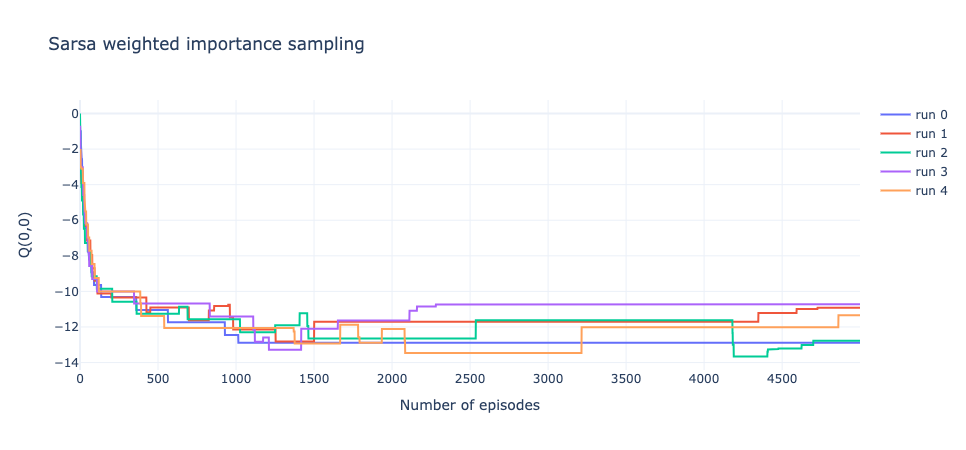

In [285]:
num_episodes = 5000

fig = go.Figure()
n_runs = 5
for i in range(n_runs):
    _, _, Q_dict = sarsa_importance_sampling(env, behavioral_policy, target_policy,
                                                                        num_episodes, True, gamma, alpha)
    Q_df = pd.DataFrame.from_dict(Q_dict, orient="index")
    fig.add_trace(go.Scatter(x=Q_df.index, y=Q_df[20], name="run " + str(i)))

fig.update_layout(title_text="Sarsa weighted importance sampling", template="plotly_white", yaxis_title="Q(0,0)", xaxis_title="Number of episodes")
fig.show()



  0%|          | 0/5000 [00:00<?, ?it/s]

  8%|▊         | 379/5000 [00:01<00:12, 378.52it/s]

 18%|█▊        | 918/5000 [00:02<00:09, 415.51it/s]

 30%|██▉       | 1488/5000 [00:03<00:07, 452.22it/s]

 40%|███▉      | 1979/5000 [00:04<00:06, 463.18it/s]

 50%|█████     | 2508/5000 [00:05<00:05, 481.08it/s]

 61%|██████    | 3052/5000 [00:06<00:03, 498.18it/s]

 71%|███████   | 3555/5000 [00:07<00:02, 499.45it/s]

 82%|████████▏ | 4089/5000 [00:08<00:01, 509.28it/s]

 92%|█████████▏| 4617/5000 [00:09<00:00, 514.63it/s]

100%|██████████| 5000/5000 [00:09<00:00, 515.05it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  6%|▋         | 315/5000 [00:01<00:14, 314.69it/s]

 17%|█▋        | 830/5000 [00:02<00:11, 356.03it/s]

 27%|██▋       | 1351/5000 [00:03<00:09, 393.34it/s]

 39%|███▉      | 1952/5000 [00:04<00:06, 438.74it/s]

 49%|████▉     | 2442/5000 [00:05<00:05, 452.88it/s]

 60%|██████    | 3007/5000 [00:06<00:04, 481.40it/s]

 72%|███████▏  | 3604/5000 [00:07<00:02, 511.05it/s]



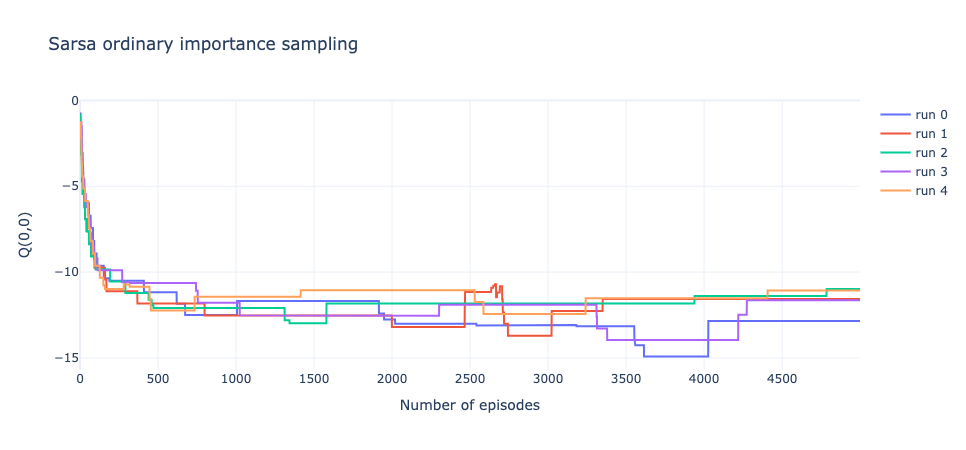

In [286]:
num_episodes = 5000

fig = go.Figure()
n_runs = 5
for i in range(n_runs):
    _, _, Q_dict = sarsa_importance_sampling(env, behavioral_policy, target_policy,
                                                                        num_episodes, False, gamma, alpha)
    Q_df = pd.DataFrame.from_dict(Q_dict, orient="index")
    fig.add_trace(go.Scatter(x=Q_df.index, y=Q_df[20], name="run " + str(i)))
    
fig.update_layout(title_text="Sarsa ordinary importance sampling", template="plotly_white", yaxis_title="Q(0,0)", xaxis_title="Number of episodes")  
fig.show()

## N-step TD importance sampling

In [28]:
def n_step_sarsa_ordinary_importance_sampling(env, behavior_policy, target_policy, num_episodes, n=1, discount_factor=1.0, alpha=0.5):
    """
    n-step SARSA algorithm: Off-policy TD control. Calculates the value function
    for a given target policy using behavior policy and ordinary importance sampling.
    
    Args:
        env: OpenAI environment.
        policy: A policy which allows us to sample actions with its sample_action method.
        Q: Q value function, numpy array Q[s,a] -> state-action value.
        num_episodes: Number of episodes to run for.
        n: number of steps
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    
    # Keep track of useful statistics
    stats = []
    
#     Q = np.ones((env.nS, env.nA)) * -100
    Q = np.zeros((env.nS, env.nA))
    
    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        behavior_policy.Q = Q
        target_policy.Q = Q
        
        s = defaultdict(lambda: defaultdict(float))
        a = defaultdict(lambda: defaultdict(float))
        r = defaultdict(lambda: defaultdict(float))
            
        s[0] = env.reset()
        a[0] = behavior_policy.sample_action(s[0])
        
        T = np.inf
        t = 0
        while True:
            if t < T:
                # Take action
                s[t+1], r[t+1], final_state, _ = env.step(a[t])
                R += r[t+1]
                i += 1
                
                if final_state:
                    T = t + 1
                else:
                    # Sample action from next state
                    a[t+1] = behavior_policy.sample_action(s[t+1])
            
            tau = t - n + 1
            
            if tau >= 0:
                # Collect states and actions included in ratio
                last_step_rho = min([tau + n, T - 1])
                first_step = tau + 1
                states = [value for key, value in s.items() if key in range(first_step, last_step_rho+1)]
                actions = [value for key, value in a.items() if key in range(first_step, last_step_rho+1)]
                
                # n-step importance sampling ratio
                rho = np.prod([(target_policy.get_probs([state],[action]))/(behavior_policy.get_probs([state],[action])) for state, action in zip(states, actions)])
                
                # n-step return
                last_step_G = min([tau + n, T])
                G = np.sum([discount_factor**(i - tau - 1) * r[i] for i in range(first_step, last_step_G)])
                if tau + n < T:
                    G += discount_factor**n * Q[s[tau+n]][a[tau+n]]
                    
                # Update Q 
                Q[s[tau]][a[tau]] += alpha * rho * (G - Q[s[tau]][a[tau]])

            if tau == T - 1:
                break
                         
            t += 1

        stats.append((i, R))
        
    Q = Qdefaultdict2array(Q, env.nA, env.nS)
        
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

In [29]:
def n_step_sarsa_weighted_importance_sampling(env, behavior_policy, target_policy, num_episodes, n=1, discount_factor=1.0, alpha=0.5):
    """
    SARSA algorithm: Off-policy TD control. Calculates the value function
    for a given target policy using behavior policy and ordinary importance sampling.
    
    Args:
        env: OpenAI environment.
        target policy: A policy which allows us to sample actions with its sample_action method.
        behaviour policy: A policy which allows us to sample actions with its sample_action method.
        Q: Q value function, numpy array Q[s,a] -> state-action value.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    
    # Keep track of useful statistics
    stats = []
    
    Q = np.zeros((env.nS, env.nA))
    C = np.zeros((env.nS, env.nA))
    
    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        behavior_policy.Q = Q
        target_policy.Q = Q
    
        s = defaultdict(lambda: defaultdict(float))
        a = defaultdict(lambda: defaultdict(float))
        r = defaultdict(lambda: defaultdict(float))

        s[0] = env.reset()
        a[0] = behavior_policy.sample_action(s[0])

        T = np.inf
        t = 0
        while True:
            if t < T:
                # Take action
                s[t+1], r[t+1], final_state, _ = env.step(a[t])
                R += r[t+1]
                i += 1

                if final_state:
                    T = t + 1
                else:
                    # Sample action from next state
                    a[t+1] = behavior_policy.sample_action(s[t+1])

            tau = t - n + 1

            if tau >= 0:
                # Collect states and actions included in ratio
                last_step_rho = min([tau + n, T - 1])
                first_step = tau + 1
                states = [value for key, value in s.items() if key in range(first_step, last_step_rho+1)]
                actions = [value for key, value in a.items() if key in range(first_step, last_step_rho+1)]

                # n-step importance sampling ratio
                rho = np.prod([(target_policy.get_probs([state],[action]))/(behavior_policy.get_probs([state],[action])) for state, action in zip(states, actions)])

                # n-step return
                last_step_G = min([tau + n, T])
                G = np.sum([discount_factor**(i - tau - 1) * r[i] for i in range(first_step, last_step_G)])
                if tau + n < T:
                    G += discount_factor**n * Q[s[tau+n]][a[tau+n]]
                    
                C[s[tau]][a[tau]] += rho
#                 Q[s][a] += W/C[s][a] * (G - Q[s][a])
                # Update Q - for weigted sampling rho/rho is 1
                Q[s[tau]][a[tau]] += alpha * rho/C[s[tau]][a[tau]] * (G - Q[s[tau]][a[tau]])

            if tau == T - 1:
                break

            t += 1

        stats.append((i, R))
        
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

In [30]:
# Reproducible
np.random.seed(42)

# set other parameters
epsilon = 0.05
discount_factor = 0.99
num_episodes = 10
alpha=0.5
Q = np.zeros((env.nS, env.nA))
behavioral_policy = EpsilonGreedyPolicy(Q, epsilon=epsilon)
target_policy = GreedyPolicy(Q)

n=1
print(f"Updating Q using weighted importance sampling ({num_episodes} episodes)")
Q_td_nstep_ordinary, td_nstep_ordinary_epsstats = n_step_sarsa_ordinary_importance_sampling(env, behavioral_policy, target_policy, 
                                                                        num_episodes, n, discount_factor, alpha)
print(f"Updating Q using weighted importance sampling ({num_episodes} episodes)")
Q_td_nstep_weighted, td_nstep_weighted_epsstats = n_step_sarsa_weighted_importance_sampling(env, behavioral_policy, target_policy, 
                                                                        num_episodes, n, discount_factor, alpha)

100%|██████████| 10/10 [00:00<00:00, 317.73it/s]

Updating Q using weighted importance sampling (10 episodes)
Updating Q using weighted importance sampling (10 episodes)


In [32]:
# check how long an episode takes under the found Q function
greedy_weighted_nstep = GreedyPolicy(Q_td_nstep_weighted)

weighted_episode_nstep = sample_episode(env, greedy_weighted_nstep)

print(f"resulting episode length ordinary nstep: {len(weighted_episode_nstep[0])}")

resulting episode length ordinary nstep: 7


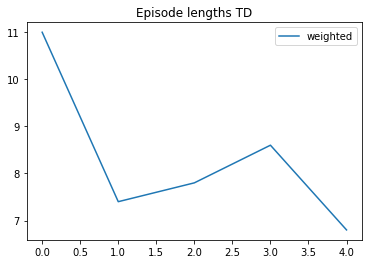

In [33]:

n = 5

rm = running_mean(td_nstep_weighted_epsstats[0], n)

# fig = go.Figure(go.Scatter(x=list(range(len(rm))), y=rm))
# fig.show()

plt.plot(rm, label="weighted")
plt.title('Episode lengths TD')
plt.legend()
# plt.gca().set_ylim([0, 100])
plt.show()

## Experiments